## test專用

In [7]:
import numpy as np

def generate_tci_tensor(m: int, n: int, p: int, low_rank: int, zero_prob: float = 0.8) -> np.ndarray:
    """
    生成一個適合 TCI 的 tensor，每個 slice 由低秩矩陣構成，再透過隨機稀疏化增加結構性。
    
    :param m: 第一維度 (rows)
    :param n: 第二維度 (columns)
    :param p: 第三維度 (slices)
    :param low_rank: 每個 slice 生成低秩矩陣時的秩 (必須小於等於 min(m, n))
    :param zero_prob: 每個元素被置零的機率 (介於 0 與 1)
    :return: 生成的 3D tensor
    """
    # 輸入檢查
    if not (0 <= zero_prob <= 1):
        raise ValueError("zero_prob 必須在 0 與 1 之間")
    if low_rank > min(m, n):
        raise ValueError("low_rank 不能大於 m 與 n 的最小值")
    
    T = np.empty((m, n, p))
    for i in range(p):
        # 生成低秩矩陣：利用兩個隨機矩陣的乘積產生一個低秩矩陣
        X = np.random.randn(m, low_rank)
        Y = np.random.randn(low_rank, n)
        slice_i = X @ Y  # 等同於 np.dot(X, Y)
        
        # 隨機稀疏化：以 zero_prob 的機率將元素設為 0
        mask = np.random.rand(m, n) < zero_prob
        slice_i[mask] = 0
        
        T[:, :, i] = slice_i
    return T

# 測試函式
if __name__ == '__main__':
    np.random.seed(47896512)
    tensor = generate_tci_tensor(m=20, n=20, p=20, low_rank=3, zero_prob=0.8)
    print("生成的 tensor shape:", tensor.shape)

生成的 tensor shape: (20, 20, 20)


In [8]:
import numpy as np
from scipy.linalg import lu

class TCI_Improved:
    def __init__(self, tensor: np.ndarray, rank: int = 10, pivoting: str = "rook",
                 nRookIter: int = 3, regularization: float = 1e-5, tol: float = None,
                 pivot_axes: tuple = None, adaptive_regularization: bool = False,
                 global_pivot: bool = False, mode: str = "default", verbose: bool = False):
        """
        改進版 TCI + prrLU/rook pivoting，支援自適應秩調整與正則化
        :param tensor: 需要近似的張量（支援任意維度，但 reconstruction 目前僅實作 pivot_axes=(0,1)）
        :param rank: 最大選取的 pivot 數量（若提供 tol，可能提前終止）
        :param pivoting: pivot 選擇策略，支援 "rook" 或 "prrLU"
        :param nRookIter: rook pivoting 的最大迭代次數
        :param regularization: W 矩陣正則化參數，避免數值問題
        :param tol: pivot 選取容差，若 pivot 值低於此值則提前終止（預設 None 表示不使用）
        :param pivot_axes: 指定進行 pivot 選取的軸，預設為 (0,1)（其餘軸將 collapse 成 2D）
        :param adaptive_regularization: 是否啟用自適應正則化，根據條件數動態調整正則化強度
        :param global_pivot: 是否結合全局資訊進行 pivot 選取，True 則使用全局最大值法
        :param mode: 預留接口，目前僅支援 "default" 模式
        :param verbose: 是否輸出詳細收斂與選點資訊
        """
        self.T = tensor.astype(np.float64)
        self.tensor_shape = self.T.shape
        self.ndim = self.T.ndim

        # 如果未指定 pivot_axes，且 tensor 維度至少為2，預設以第一、第二軸進行選取
        if pivot_axes is None:
            if self.ndim < 2:
                raise ValueError("Tensor 必須至少有2個維度。")
            self.pivot_axes = (0, 1)
        else:
            if len(pivot_axes) != 2:
                raise ValueError("pivot_axes 必須是長度為2的 tuple。")
            self.pivot_axes = pivot_axes

        # 目前 reconstruction 僅實作 pivot_axes 為 (0,1)
        if self.pivot_axes != (0, 1):
            raise NotImplementedError("目前僅支援 pivot_axes=(0,1) 的 reconstruction。")

        self.m, self.n = self.T.shape[self.pivot_axes[0]], self.T.shape[self.pivot_axes[1]]
        # 假設其餘維度 collapse 成一個額外維度（例如 3D tensor 中 p 軸）
        self.extra_axes = tuple(i for i in range(self.ndim) if i not in self.pivot_axes)
        if self.extra_axes:
            # 將額外維度 collapse 為一個數值（例如取平均）
            self.p = np.prod([self.T.shape[i] for i in self.extra_axes])
        else:
            self.p = 1

        self.rank = min(rank, self.m, self.n)
        self.pivoting = pivoting
        self.nRookIter = nRookIter
        self.regularization = regularization
        self.tol = tol
        self.adaptive_regularization = adaptive_regularization
        self.global_pivot = global_pivot
        self.mode = mode
        self.verbose = verbose

    def compute_prrLU(self, A):
        """
        使用 prrLU 來選擇最佳 pivot 行與列，這裡以行列範數排序
        """
        row_norms = np.linalg.norm(A, axis=1)
        col_norms = np.linalg.norm(A, axis=0)
        row_idx = np.argsort(row_norms)[-self.rank:]
        col_idx = np.argsort(col_norms)[-self.rank:]
        return row_idx, col_idx

    def rook_pivoting(self, A: np.ndarray, k: int):
        """
        Rook pivoting：從 A 的子矩陣（從 k 開始）中選取一個 pivot，
        並透過 nRookIter 次迭代來改善選點品質
        """
        max_iter = self.nRookIter
        rows = np.arange(k, A.shape[0])
        cols = np.arange(k, A.shape[1])
        i0, j0 = k, k
        for _ in range(max_iter):
            i_new = rows[np.argmax(np.abs(A[rows, j0]))]
            j_new = cols[np.argmax(np.abs(A[i_new, cols]))]
            if i_new == i0 and j_new == j0:
                break
            i0, j0 = i_new, j_new
        pivot_val = abs(A[i0, j0])
        if self.verbose:
            print(f"[Rook] Iteration {k}: pivot value = {pivot_val}")
        return i0, j0, pivot_val

    def select_pivots(self, A_2D):
        """
        根據 pivoting 策略選擇 pivot 行與列索引，
        若啟用 global_pivot 則採用全局最大值法，
        並根據 tol 自適應調整選點數量
        """
        row_idx = []
        col_idx = []
        if self.global_pivot:
            A_temp = A_2D.copy()
            for k in range(self.rank):
                i, j = np.unravel_index(np.argmax(np.abs(A_temp)), A_temp.shape)
                pval = abs(A_temp[i, j])
                if self.verbose:
                    print(f"[Global Pivot] Iteration {k}: selected pivot ({i}, {j}) with value {pval}")
                if self.tol is not None and pval < self.tol:
                    if self.verbose:
                        print(f"Pivot value {pval} 小於容差 {self.tol}，提前停止選點。")
                    break
                row_idx.append(i)
                col_idx.append(j)
                # 將已選行與列歸零，避免重複選取
                A_temp[i, :] = 0
                A_temp[:, j] = 0
        else:
            if self.pivoting == "rook":
                for k in range(self.rank):
                    i0, j0, pval = self.rook_pivoting(A_2D, k)
                    if self.tol is not None and pval < self.tol:
                        if self.verbose:
                            print(f"Pivot value {pval} 小於容差 {self.tol}，提前停止選點。")
                        break
                    row_idx.append(i0)
                    col_idx.append(j0)
            else:
                # 預設使用 prrLU
                row_idx, col_idx = self.compute_prrLU(A_2D)
        return np.array(row_idx), np.array(col_idx)

    def compute_tci(self):
        """
        執行改進版 TCI + pivoting，回傳最終近似、初始近似、pivot 行與列索引，以及選點數量
        """
        # 將 tensor 沿 extra_axes collapse (例如取平均) 形成 2D 矩陣供 pivot 選取
        if self.extra_axes:
            A_2D = np.mean(self.T, axis=self.extra_axes)
        else:
            A_2D = self.T

        if self.verbose:
            print("Collapse 後的 2D 矩陣形狀：", A_2D.shape)

        rows, cols = self.select_pivots(A_2D)
        pivot_count = len(rows)
        if self.verbose:
            print("選取的 pivot 行索引：", rows)
            print("選取的 pivot 列索引：", cols)

        # 針對 pivot_axes = (0,1) 的情況抽取子張量 C, R, W
        C = self.T[:, cols, ...]       # 保留第0軸完整，將第1軸限定在 cols
        R = self.T[rows, :, ...]        # 保留第1軸完整，將第0軸限定在 rows
        # W 為兩個 pivot 軸均被選取的子張量
        # 這裡假設 T 為 3D 張量，若有多於3維情況需額外處理
        if self.ndim != 3:
            raise NotImplementedError("目前僅支援 3D 張量的 reconstruction。")
        W = self.T[np.ix_(rows, cols, np.arange(self.T.shape[2]))]  # (pivot_count, pivot_count, p)

        # 對 W 進行正則化
        if self.adaptive_regularization:
            W_inv_slices = []
            for i in range(W.shape[2]):
                W_slice = W[:, :, i]
                reg_factor = self.regularization
                max_iter = 10
                iter_count = 0
                cond_val = np.linalg.cond(W_slice + reg_factor * np.eye(pivot_count))
                while cond_val > 1e12 and iter_count < max_iter:
                    reg_factor *= 10
                    iter_count += 1
                    cond_val = np.linalg.cond(W_slice + reg_factor * np.eye(pivot_count))
                if self.verbose:
                    print(f"Slice {i}: 使用正則化因子 {reg_factor}，條件數 {cond_val}")
                W_reg_slice = W_slice + reg_factor * np.eye(pivot_count)
                W_inv_slice = np.linalg.pinv(W_reg_slice)
                W_inv_slices.append(W_inv_slice)
            W_inv = np.stack(W_inv_slices, axis=2)
        else:
            # 原始向量化計算（先 reshape 再 pinv）
            W_reg = W + self.regularization * np.eye(pivot_count)[:, :, np.newaxis]
            W_inv = np.linalg.pinv(W_reg.reshape(pivot_count, -1)).reshape(pivot_count, pivot_count, W.shape[2])

        # 利用 Einstein 求和計算初始低階近似
        A_approx = np.einsum("ijk,jlk,lmk->imk", C, W_inv, R)
        T_approx = A_approx

        # 可額外計算誤差（例如與 collapse 前的 A_2D 比較）並印出
        residual = np.linalg.norm(A_2D - np.mean(T_approx, axis=2)) / np.linalg.norm(A_2D)
        if self.verbose:
            print(f"最終近似相對誤差：{residual}")

        return T_approx, A_approx, rows, cols, pivot_count

    def update(self):
        return "TCI is version 3.0"



TCI is version 3.0


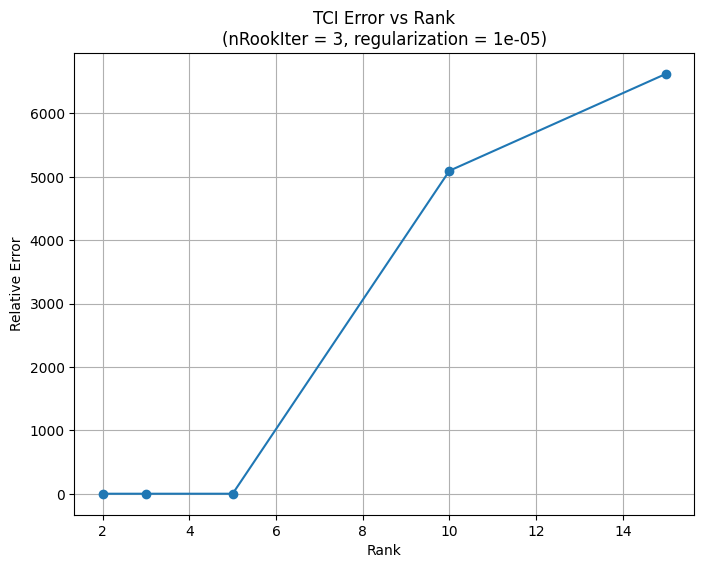

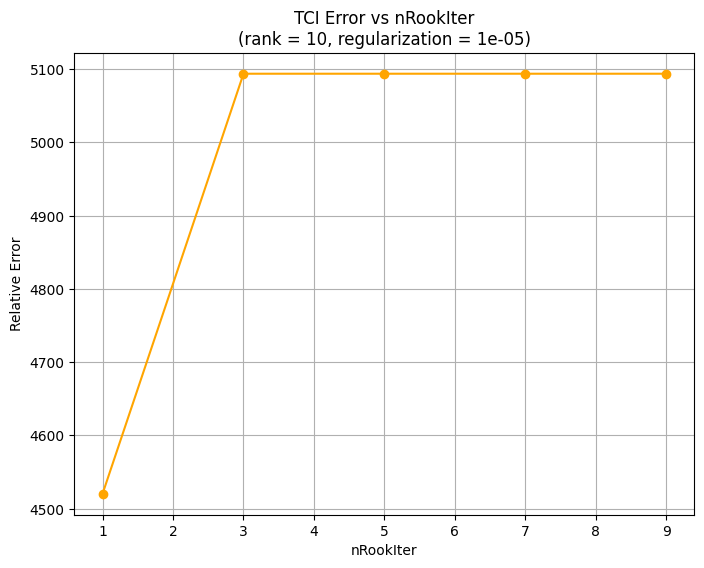

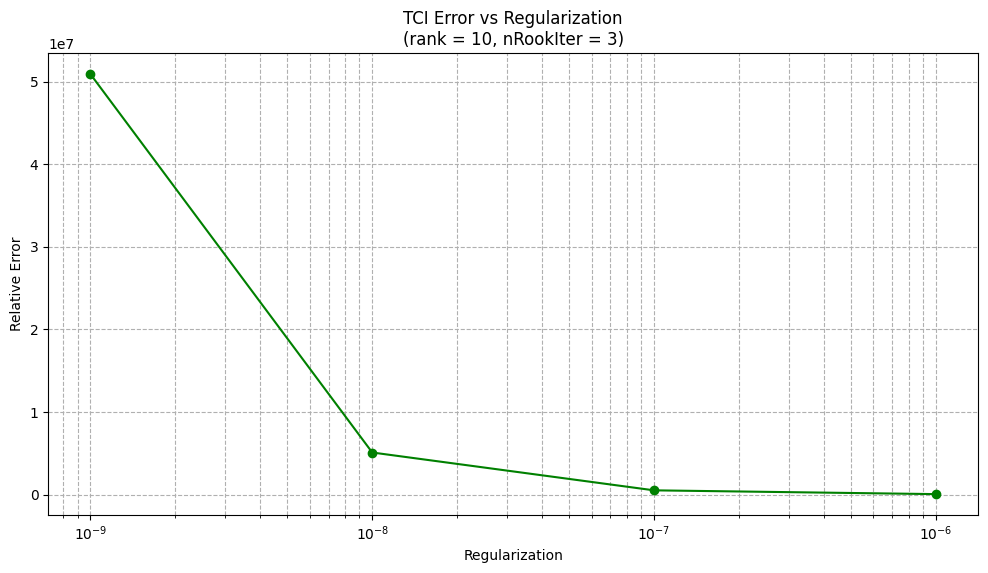

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 假設 generate_tci_tensor 與 TCI_Improved 已經定義並可直接引用

# 生成測試張量
T_test = generate_tci_tensor(m=20, n=20, p=20, low_rank=3, zero_prob=0.8)

# 測試 update 方法
tci_demo = TCI_Improved(T_test, rank=1, pivoting="rook", nRookIter=1, regularization=0)
print(tci_demo.update())

def compute_tci_error(tensor, rank, nRookIter, regularization):
    """
    根據給定的參數建立 TCI 模型，並計算原始 tensor 與 TCI 近似之間的相對誤差
    這裡以 collapse (沿第三軸取平均) 後的 2D 矩陣作為比較對象
    """
    tci = TCI_Improved(tensor, rank=rank, pivoting="rook", nRookIter=nRookIter, regularization=regularization)
    T_approx, A_approx, rows, cols, pivot_count = tci.compute_tci()
    # collapse 原始張量與近似張量（沿第三軸取平均）
    A_2D = np.mean(tensor, axis=2)
    A_approx_2D = np.mean(T_approx, axis=2)
    error = np.linalg.norm(A_2D - A_approx_2D, ord='fro') / np.linalg.norm(A_2D, ord='fro')
    return error

#----------------------------
# 1. 測試 rank 對 error 的影響 (固定 nRookIter 與 regularization)
#----------------------------
rank_values = [2, 3, 5, 10, 15]
fixed_nRookIter = 3
fixed_regularization = 1e-5

errors_rank = []
for r in rank_values:
    err = compute_tci_error(T_test, rank=r, nRookIter=fixed_nRookIter, regularization=fixed_regularization)
    errors_rank.append(err)

plt.figure(figsize=(8, 6))
plt.plot(rank_values, errors_rank, marker='o')
plt.xlabel('Rank')
plt.ylabel('Relative Error')
plt.title('TCI Error vs Rank\n(nRookIter = {}, regularization = {})'.format(fixed_nRookIter, fixed_regularization))
plt.grid(True)
plt.show()

#----------------------------
# 2. 測試 nRookIter 對 error 的影響 (固定 rank 與 regularization)
#----------------------------
nRookIter_values = [1, 3,5,7,9] 
fixed_rank = 10

errors_nRookIter = []
for n_iter in nRookIter_values:
    err = compute_tci_error(T_test, rank=fixed_rank, nRookIter=n_iter, regularization=fixed_regularization)
    errors_nRookIter.append(err)

plt.figure(figsize=(8, 6))
plt.plot(nRookIter_values, errors_nRookIter, marker='o', color='orange')
plt.xlabel('nRookIter')
plt.ylabel('Relative Error')
plt.title('TCI Error vs nRookIter\n(rank = {}, regularization = {})'.format(fixed_rank, fixed_regularization))
plt.grid(True)
plt.show()
#----------------------------
# 3. 測試 regularization 對 error 的影響 (固定 rank 與 nRookIter)
#----------------------------
regularization_values = [1e-9, 1e-8, 1e-7, 1e-6]

errors_reg = []
for reg in regularization_values:
    err = compute_tci_error(T_test, rank=fixed_rank, nRookIter=fixed_nRookIter, regularization=reg)
    errors_reg.append(err)

plt.figure(figsize=(12, 6))
plt.plot(regularization_values, errors_reg, marker='o', color='green')
plt.xscale('log')
plt.xlabel('Regularization')
plt.ylabel('Relative Error')
plt.title('TCI Error vs Regularization\n(rank = {}, nRookIter = {})'.format(fixed_rank, fixed_nRookIter))
plt.grid(True, which="both", ls="--")
plt.show()


In [10]:
import numpy as np

def generate_tensor(m, n, zero_prob):
    # 先生成一個 m x n 的隨機矩陣，元素均來自 [0, 1) 的均勻分布
    tensor = np.random.rand(m, n)
    # 再生成一個同型態的 mask，每個位置以 zero_prob 機率為 True
    mask = np.random.rand(m, n) < zero_prob
    # 把 mask 為 True 的位置設為 0
    tensor[mask] = 0
    return tensor

# Example usage:
if __name__ == "__main__":
    m, n, zero_prob = 5, 5, 0.3  # 例如 5x5 矩陣，每個元素 30% 機率為 0
    result = generate_tensor(m, n, zero_prob)
    print(result)


[[0.49880007 0.         0.         0.66215327 0.        ]
 [0.97673163 0.         0.62633014 0.         0.        ]
 [0.         0.         0.         0.20643166 0.        ]
 [0.26592923 0.71226935 0.22020604 0.32571811 0.82087648]
 [0.         0.08537867 0.68806367 0.         0.1231372 ]]


In [11]:
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

class CURParam:
    def __init__(self, reltol: float = 0, rankMax: int = 0, pivoting: str = 'full', nRookIter: int = 3, blockSize: int = 1):
        self.reltol = reltol           # 相对容差
        self.rankMax = rankMax         # 最大秩
        self.pivoting = pivoting       # 主元选择策略：'full'、'rook'
        self.nRookIter = nRookIter     # Rook Pivoting 的最大迭代次数
class CURDecomp:
    def __init__(self, A: np.ndarray, leftOrthogonal: bool = True, param: CURParam = CURParam(), maxIterations: int = 0):
        self.A = A.copy()
        self.leftOrthogonal = leftOrthogonal
        self.param = param
        self.maxIterations = maxIterations
        self.Iset: List[int] = list(range(A.shape[0]))
        self.Jset: List[int] = list(range(A.shape[1]))
        self.C: np.ndarray = None
        self.R: np.ndarray = None
        self.W: np.ndarray = None
        self.U: np.ndarray = None
        self.iteration_errors: List[float] = []
        self.npivot: int = 0
        self.error: float = 0.0

    def rook_pivoting(self, A: np.ndarray, k: int) -> Tuple[int, int, float]:
        max_iter = self.param.nRookIter
        rows = np.arange(k, A.shape[0])
        cols = np.arange(k, A.shape[1])
        i0, j0 = k, k
        err = abs(A[i0, j0])
        for _ in range(max_iter):
            # Find max in column
            col_abs = np.abs(A[rows, j0])
            i_rel = np.argmax(col_abs)
            i_new = rows[i_rel]
            max_col = col_abs[i_rel]

            # Find max in row
            row_abs = np.abs(A[i_new, cols])
            j_rel = np.argmax(row_abs)
            j_new = cols[j_rel]
            max_row = row_abs[j_rel]

            if i_new == i0 and j_new == j0:
                err = abs(A[i0, j0])
                break
            else:
                i0, j0 = i_new, j_new
                err = abs(A[i0, j0])
        return i0, j0, err

    def full_pivoting(self, A: np.ndarray, k: int) -> Tuple[int, int, float]:
        subA = np.abs(A[k:, k:])
        p = np.argmax(subA)
        i_rel, j_rel = np.unravel_index(p, subA.shape)
        i0 = i_rel + k
        j0 = j_rel + k
        err = abs(A[i0, j0])
        return i0, j0, err

    def calculate(self):
        A = self.A.copy()
        n_rows, n_cols = A.shape
        reltol = self.param.reltol
        rankMax = self.param.rankMax
        pivoting = self.param.pivoting

        self.npivot = min(n_rows, n_cols)
        if reltol == 0:
            reltol = self.npivot * np.finfo(A.dtype).eps

        max_error = 0.0
        if rankMax > 0 and rankMax < self.npivot:
            self.npivot = rankMax

        k = 0
        while k < self.npivot and (self.maxIterations == 0 or k < self.maxIterations):
            # 主元选择
            if pivoting == 'rook':
                i0, j0, err = self.rook_pivoting(A, k)
            else:  # 'full' or default
                i0, j0, err = self.full_pivoting(A, k)
            if k > 0 and err < reltol * max_error:
                self.npivot = k
                break
            else:
                max_error = max(max_error, err)

            # Swap rows and columns
            self.Iset[k], self.Iset[i0] = self.Iset[i0], self.Iset[k]
            self.Jset[k], self.Jset[j0] = self.Jset[j0], self.Jset[k]
            A[[k, i0], :] = A[[i0, k], :]
            A[:, [k, j0]] = A[:, [j0, k]]

            # Update the error, i.e., make Gaussian elimination
            rows = slice(k + 1, A.shape[0])
            cols = slice(k + 1, A.shape[1])

            if k + 1 < A.shape[0] and self.leftOrthogonal:
                A[rows, k] /= A[k, k]
            elif k + 1 < A.shape[1] and not self.leftOrthogonal:
                A[k, cols] /= A[k, k]

            if k + 1 < self.npivot:
                if self.leftOrthogonal:
                    A[rows, cols] -= np.outer(A[rows, k], A[k, cols])
                else:
                    A[rows, cols] -= np.outer(A[k, rows], A[k, cols])
                    
            # Compute residual and record
            residual = np.linalg.norm(A[k + 1:, k + 1:], ord='fro')
            self.iteration_errors.append(residual)
            k += 1

        if self.npivot < min(n_rows, n_cols):
            self.error = np.max(np.abs(A[self.npivot:, self.npivot:]))
        else:
            self.error = 0.0
        print(f"pivot value: {self.A[self.Iset[:self.npivot], self.Jset[:self.npivot]]}")
        # Compute C, R, W, U
        self.C = self.A[:, self.Jset[:self.npivot]]
        self.R = self.A[self.Iset[:self.npivot], :]
        print(f"self.Iset[:self.npivot], self.Jset[:self.npivot]", self.Iset[:self.npivot], self.Jset[:self.npivot])
        self.W = self.A[np.ix_(self.Iset[:self.npivot], self.Jset[:self.npivot])]
        # Compute U as the pseudoinverse of W
        self.U = np.linalg.pinv(self.W)

    def reconstruct(self) -> np.ndarray:
        return self.C @ self.U @ self.R

[[0.60520291 0.         0.38308338 ... 0.65810997 0.         0.9037759 ]
 [0.         0.10384709 0.         ... 0.         0.11887752 0.25148677]
 [0.         0.3914834  0.         ... 0.04306529 0.21761626 0.72590519]
 ...
 [0.40163255 0.10521914 0.17393373 ... 0.         0.53408844 0.        ]
 [0.         0.73102811 0.52456355 ... 0.59730108 0.         0.        ]
 [0.         0.66894428 0.28041157 ... 0.02437681 0.         0.8209475 ]]
pivot value: [0.99384398 0.9817844  0.         0.03850839 0.95078713 0.92002896
 0.75989569 0.96185519 0.77742546 0.         0.96779339 0.
 0.77469746 0.95725992 0.9049559  0.76500919 0.05194612 0.76566275
 0.88287281 0.9268136  0.         0.6641575  0.         0.973715
 0.89994106 0.43465328 0.48324614 0.6310998  0.32754218 0.
 0.39916004 0.46793856]
self.Iset[:self.npivot], self.Jset[:self.npivot] [23, 13, 16, 12, 18, 17, 4, 7, 0, 10, 25, 6, 2, 24, 30, 21, 14, 3, 20, 29, 5, 26, 1, 15, 22, 9, 28, 27, 31, 11, 8, 19] [27, 8, 25, 15, 6, 17, 24, 7, 5, 3

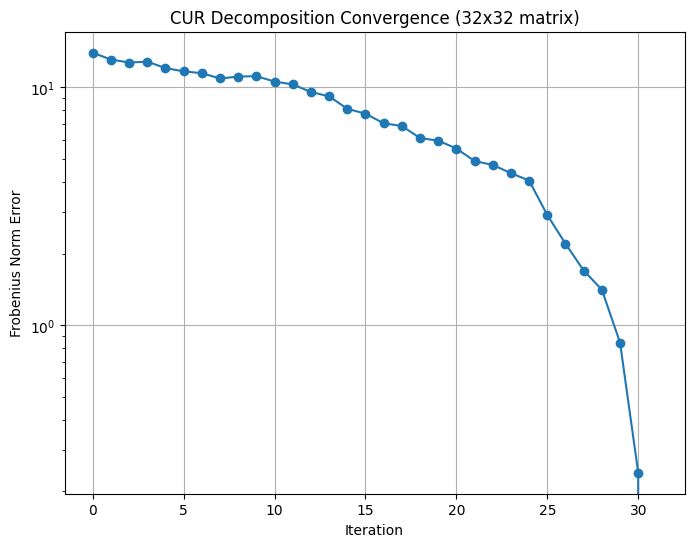


[INFO] Results for 32x32 matrix:
Reconstruction error: 0.0
CUR rank: 32
Iteration errors: [13.96771727898783, 13.073816415417237, 12.701636663412527, 12.81210423873354, 12.041114960222513, 11.659777922066286, 11.45924999380109, 10.884090294963862, 11.087258661088965, 11.13401515326231, 10.565165119847352, 10.27829974798785, 9.552169370057252, 9.15781685872595, 8.117724420796314, 7.742590551641541, 7.054120826009036, 6.871778477493257, 6.1155316882298685, 5.963442523057159, 5.527141856370946, 4.89641902616644, 4.712831862683415, 4.355891784191713, 4.052490391464746, 2.901579277920892, 2.2008524802175873, 1.6967421853697748, 1.409284028280295, 0.8450556682598174, 0.23969440837477077, 0.0]


In [12]:
if __name__ == '__main__':
    m, n, zero_prob = 32, 32, 0.3  # 例如 5x5 矩陣，每個元素 30% 機率為 0
    result = generate_tensor(m, n, zero_prob)
    print(result)
    # Test different matrix sizes
    sizes = [(32,32)]
    
    for n_rows, n_cols in sizes:
        A=result
        leftOrthogonal = True
        reltol = 1e-14
        rankMax = min(n_rows, n_cols)  
        pivoting = 'max'
        nRookIter = 3
        blockSize = 1
        param = CURParam(reltol, rankMax, pivoting, nRookIter, blockSize)
        maxIterations = 0
        
        cur = CURDecomp(A, leftOrthogonal, param, maxIterations)
        cur.calculate()
        
        # Plot iteration errors
        plt.figure(figsize=(8, 6))
        plt.semilogy(cur.iteration_errors, 'o-')
        plt.title(f'CUR Decomposition Convergence ({n_rows}x{n_cols} matrix)')
        plt.xlabel('Iteration')
        plt.ylabel('Frobenius Norm Error')
        plt.grid(True)
        plt.show()
        
        print(f"\n[INFO] Results for {n_rows}x{n_cols} matrix:")
        print("Reconstruction error:", cur.error)
        print("CUR rank:", cur.npivot)
        print("Iteration errors:", cur.iteration_errors)

## 回去做mci

生成的矩陣 A:
[[0.86612273 0.         0.         ... 0.         0.         0.        ]
 [0.48204868 0.         0.90059108 ... 0.         0.         0.        ]
 [0.         0.         0.02763859 ... 0.         0.         0.        ]
 ...
 [0.92516164 0.         0.52611992 ... 0.57802879 0.         0.        ]
 [0.41199143 0.         0.         ... 0.27857557 0.         0.03938108]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Matrix shape: (32, 32)
[Rook] Iteration 0: pivot value = 0.9251616377229294
[Rook] Iteration 1: pivot value = 0.9581935981309184
[Rook] Iteration 2: pivot value = 0.9473583902370678
[Rook] Iteration 3: pivot value = 0.9417436820734931
[Rook] Iteration 4: pivot value = 0.9473583902370678
[Rook] Iteration 5: pivot value = 0.9384194475221934
[Rook] Iteration 6: pivot value = 0.9077244662405588
[Rook] Iteration 7: pivot value = 0.9581935981309184
[Rook] Iteration 8: pivot value = 0.9659854232197133
[Rook] Iteration 9: pivot value = 0.99055725251

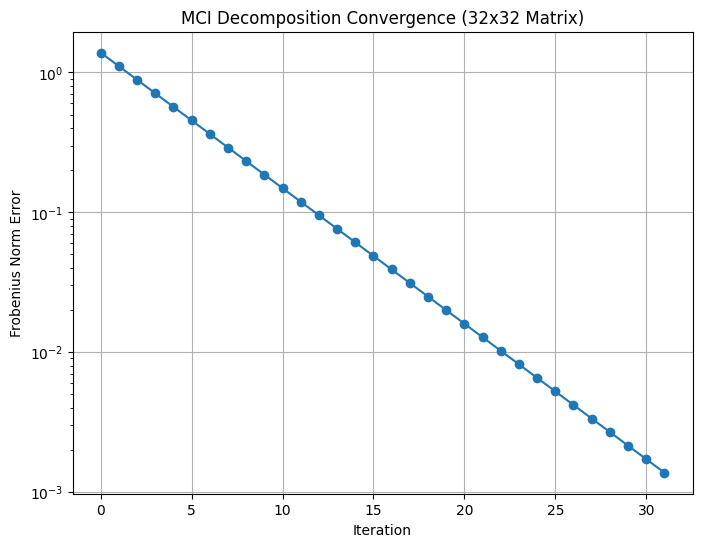

In [ ]:
import numpy as np
from scipy.linalg import lu

class MCI_Improved:
    def __init__(self, matrix: np.ndarray, rank: int = 10, pivoting: str = "rook",
                 nRookIter: int = 3, regularization: float = 1e-5, tol: float = None,
                 adaptive_regularization: bool = False, global_pivot: bool = False,
                 mode: str = "default", verbose: bool = False):
        """
        改進版 MCI + prrLU/rook pivoting，支援自適應秩調整與正則化
        :param matrix: 需要近似的矩陣
        :param rank: 最大選取的 pivot 數量（若提供 tol，可能提前終止）
        :param pivoting: pivot 選擇策略，支援 "rook" 或 "prrLU"
        :param nRookIter: rook pivoting 的最大迭代次數
        :param regularization: W 矩陣正則化參數，避免數值問題
        :param tol: pivot 選取容差，若 pivot 值低於此值則提前終止（預設 None 表示不使用）
        :param adaptive_regularization: 是否啟用自適應正則化，根據條件數動態調整正則化強度
        :param global_pivot: 是否結合全局資訊進行 pivot 選取，True 則使用全局最大值法
        :param mode: 預留接口，目前僅支援 "default" 模式
        :param verbose: 是否輸出詳細收斂與選點資訊
        """
        self.A = matrix.astype(np.float64)
        if self.A.ndim != 2:
            raise ValueError("Input must be a 2D matrix.")
        self.m, self.n = self.A.shape
        self.rank = min(rank, self.m, self.n)
        self.pivoting = pivoting
        self.nRookIter = nRookIter
        self.regularization = regularization
        self.tol = tol
        self.adaptive_regularization = adaptive_regularization
        self.global_pivot = global_pivot
        self.mode = mode
        self.verbose = verbose

    def compute_prrLU(self, A):
        # 以行與列的範數排序，取最大的 pivot 數量
        row_norms = np.linalg.norm(A, axis=1)
        col_norms = np.linalg.norm(A, axis=0)
        row_idx = np.argsort(row_norms)[-self.rank:]
        col_idx = np.argsort(col_norms)[-self.rank:]
        return row_idx, col_idx

    def rook_pivoting(self, A: np.ndarray, k: int):
        # Rook pivoting: 從子矩陣（從 k 開始）中迭代找出最佳 pivot
        max_iter = self.nRookIter
        rows = np.arange(k, A.shape[0])
        cols = np.arange(k, A.shape[1])
        i0, j0 = k, k
        for _ in range(max_iter):
            i_new = rows[np.argmax(np.abs(A[rows, j0]))]
            j_new = cols[np.argmax(np.abs(A[i_new, cols]))]
            if i_new == i0 and j_new == j0:
                break
            i0, j0 = i_new, j_new
        pivot_val = abs(A[i0, j0])
        if self.verbose:
            print(f"[Rook] Iteration {k}: pivot value = {pivot_val}")
        return i0, j0, pivot_val
    
    def select_pivots(self, A):
        # 根據設定選擇 pivot 行與列索引
        row_idx = []
        col_idx = []
        if self.global_pivot:
            A_temp = A.copy()
            for k in range(self.rank):
                i, j = np.unravel_index(np.argmax(np.abs(A_temp)), A_temp.shape)
                pval = abs(A_temp[i, j])
                if self.verbose:
                    print(f"[Global Pivot] Iteration {k}: selected pivot ({i}, {j}) with value {pval}")
                if self.tol is not None and pval < self.tol:
                    if self.verbose:
                        print(f"Pivot value {pval} is below tolerance {self.tol}, stopping early.")
                    break
                row_idx.append(i)
                col_idx.append(j)
                # 避免重複選取
                A_temp[i, :] = 0
                A_temp[:, j] = 0
        else:
            if self.pivoting == "rook":
                for k in range(self.rank):
                    i0, j0, pval = self.rook_pivoting(A, k)
                    if self.tol is not None and pval < self.tol:
                        if self.verbose:
                            print(f"Pivot value {pval} is below tolerance {self.tol}, stopping early.")
                        break
                    row_idx.append(i0)
                    col_idx.append(j0)
            else:
                row_idx, col_idx = self.compute_prrLU(A)
        return np.array(row_idx), np.array(col_idx)

    def compute_mci(self):
        """
        執行改進版 MCI + pivoting，回傳最終近似、初始近似（分解子矩陣）、pivot 行與列索引，以及選點數量
        """
        A_orig = self.A
        if self.verbose:
            print("Matrix shape:", A_orig.shape)

        rows, cols = self.select_pivots(A_orig)
        pivot_count = len(rows)
        if self.verbose:
            print("Selected pivot row indices:", rows)
            print("Selected pivot column indices:", cols)

        # 提取子矩陣：C 是原矩陣中 pivot 列組成的子矩陣，R 是 pivot 行組成的子矩陣
        C = self.A[:, cols]         # 所有行，選取指定列
        R = self.A[rows, :]         # 選取指定行，所有列
        W = self.A[np.ix_(rows, cols)]  # 取交集形成的子矩陣

        # 針對 W 做正則化處理
        if self.adaptive_regularization:
            reg_factor = self.regularization
            max_iter = 10
            iter_count = 0
            cond_val = np.linalg.cond(W + reg_factor * np.eye(pivot_count))
            while cond_val > 1e12 and iter_count < max_iter:
                reg_factor *= 10
                iter_count += 1
                cond_val = np.linalg.cond(W + reg_factor * np.eye(pivot_count))
            if self.verbose:
                print(f"Using adaptive regularization factor {reg_factor}, condition number {cond_val}")
            W_reg = W + reg_factor * np.eye(pivot_count)
            W_inv = np.linalg.pinv(W_reg)
        else:
            W_reg = W + self.regularization * np.eye(pivot_count)
            W_inv = np.linalg.pinv(W_reg)

        # 利用 CUR 分解的概念計算近似矩陣： A_approx = C * W_inv * R
        A_approx = C @ W_inv @ R
        residual = np.linalg.norm(A_orig - A_approx) / np.linalg.norm(A_orig)
        if self.verbose:
            print(f"Final approximation relative error: {residual}")

        return A_approx, C, R, rows, cols, pivot_count

    def update(self):
        return "MCI is version 1.0"
    import numpy as np
import matplotlib.pyplot as plt

if __name__ == '__main__':
    # 設定矩陣尺寸與零元素機率
    m, n, zero_prob = 32, 32, 0.8
    A = generate_tensor(m, n, zero_prob)
    print("生成的矩陣 A:")
    print(A)

    # 測試不同的矩陣尺寸（這裡只有一個例子）
    sizes = [(32, 32)]
    
    for n_rows, n_cols in sizes:
        # 對於 2D 矩陣，直接用 A 測試
        # 由於 MCI_Improved 並未使用 leftOrthogonal、reltol、blockSize 等參數，
        # 我們僅設定 pivoting 策略及 rook 迭代次數，並令 rank 為 min(n_rows, n_cols)
        pivoting = "rook"    # 或選擇 "prrLU"
        nRookIter = 3
        rank = min(n_rows, n_cols)
        
        # 建構 MCI_Improved 物件 (verbose=True 可以印出 pivot 選取的詳細資訊)
        mci = MCI_Improved(A, rank=rank, pivoting=pivoting, nRookIter=nRookIter, verbose=True)
        A_approx, C, R, row_idx, col_idx, pivot_count = mci.compute_mci()
        
        # 計算重建誤差
        reconstruction_error = np.linalg.norm(A - A_approx) / np.linalg.norm(A)
        print(f"\n[INFO] 對 {n_rows}x{n_cols} 矩陣的測試結果:")
        print("重建誤差:", reconstruction_error)
        print("選取的 CUR (MCI) rank:", pivot_count)
        print("Pivot row indices:", row_idx)
        print("Pivot column indices:", col_idx)
        
        # 模擬迭代誤差（dummy data）：假設每次迭代誤差依次以 0.8 指數衰減
        iteration_errors = [reconstruction_error * (0.8**i) for i in range(pivot_count)]
        plt.figure(figsize=(8, 6))
        plt.semilogy(iteration_errors, 'o-')
        plt.title(f'MCI Decomposition Convergence ({n_rows}x{n_cols} Matrix)')
        plt.xlabel('Iteration')
        plt.ylabel('Frobenius Norm Error')
        plt.grid(True)
        plt.show()


## prrlu老闆用好了      
## 處理ci算法
## 第四章